## 「有」加入投資節能設備的條件

* 混合整數規劃

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

In [2]:
# Create a new model
model = gp.Model("2023_12_16_MIP")

In [3]:
# Set parameters
order1 = 3  # Numbers of order
order2 = 3
process = 2  # Numbers of process
machine = 2  # Numbers of machine
M = 1000000  # A very large number
W = np.array([5, 8, 2])  # Order weight
Q = np.array([43162, 55478, 41275])  # Quantity
D = np.array([2786, 2590, 4195])  # Due date

V = np.array([[[25.0, 25.0], [45.0, 45.0]],
              [[35.0, 35.0], [60.0, 60.0]],
              [[26.0, 26.0], [47.0, 47.0]]])

S = np.array([[[50, 50], [50, 50]],
              [[50, 50], [30, 30]],
              [[40, 40], [50, 50]]])

PC = np.array([[[299, 299], [381, 381]],
               [[296, 296], [260, 260]],
               [[84, 84], [326, 326]]])  # Production cost

SC = np.array([[[60, 60], [76, 76]],
               [[59, 59], [52, 52]],
               [[17, 17], [65, 65]]])  # Setup cost


Phi_hat = np.zeros((process, machine))  # Production rate which invest the machine
for i1 in range(order1):
    Phi_hat[0, :] = 1.5
    Phi_hat[1, :] = 1.5

KW = np.array([2, 2])  # Machine power rate
Eplison = 0.8  # Machine energy-efficency rate
CEF = 4  # Carbon emission factor
GCE = 500  # Government carbon emission cap
CP = 300  # Carbon price
Alpha = 100  # Order unfulfilled penalty
Beta = np.array([2000000, 2000000])  # Investment cost on increase production rate
Delta = np.array([7000000, 7000000])# Investment cost on increase energy-efficent

In [4]:
# Create decision variables
x = model.addVars(order1, process, machine, vtype = GRB.BINARY, name = 'x')
y = model.addVars(order1, order2, process, machine, vtype = GRB.BINARY, name = 'y')
z = model.addVars(order1, order2, process, machine, vtype = GRB.BINARY, name = 'z')
f = model.addVars(order1, process, lb = 0, vtype = GRB.CONTINUOUS, name = 'f')
c = model.addVars(order1, lb = 0, vtype=GRB.CONTINUOUS, name ='c')
st = model.addVars(order1, process, machine, lb = 0, vtype=GRB.CONTINUOUS, name = 'st')
pt = model.addVars(order1, process, machine, lb = 0, vtype=GRB.CONTINUOUS, name = 'pt')
sm = model.addVars(order1, process, lb = 0, vtype = GRB.CONTINUOUS, name = 'sm')
pm = model.addVars(order1, process, lb = 0, vtype = GRB.CONTINUOUS, name = 'pm')
ec = model.addVars(order1, process, machine, lb = 0, vtype = GRB.INTEGER, name = 'ec')
em = model.addVars(order1, process, machine, lb = 0, vtype = GRB.INTEGER, name = 'em')
cce = model.addVar(lb = 0, vtype = GRB.INTEGER, name = 'cce')
w = model.addVar(vtype = GRB.BINARY, name = 'w')
phi = model.addVars(process, machine, vtype = GRB.BINARY, name = 'phi')
eta = model.addVars(process, machine, vtype = GRB.BINARY, name = 'eta')
ept = model.addVars(order1, process, machine, lb = 0, vtype = GRB.INTEGER, name = 'ept')
TC = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC')
TC1 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC1')
TC2 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC2')
TC3 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC3')
TC4 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC4')
TC5 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC5')
TC6 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC6')
TC7 = model.addVar(vtype = GRB.CONTINUOUS, name = 'TC7')

In [5]:
######## The function of Production time ########
P = {}
for i1 in range(order1):
    for j  in range(process):
        for k in range(machine):
            P[i1, j, k] = (Q[i1] / (V[i1, j, k] * Phi_hat[j, k])) * phi[j, k] + (Q[i1] / V[i1, j, k]) * (1 - phi[j, k])

            
######## The function of Buying or Selling Carbon Credit ########
BCC = cce - GCE  # Buy credits
SCC = GCE - cce  # Sell credits


######## The function of electric used ########
E = {}
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            E[i1, j, k] = KW[j] * Eplison * eta[j, k] + KW[j] * (1 - eta[j, k])

In [6]:
# Set objective function
model.setObjective(TC1 + TC2 + TC3 + TC4 - TC5 + TC6 + TC7, GRB.MINIMIZE)

In [7]:
######## Production Schedule constraints ########
# constraint 1
for i1 in range(order1):
    model.addConstr(c[i1] >= f[i1, process - 1], 'c1_%d' % i1)

# constraint 2
for i1 in range(order1):
    for j in range(process):
        model.addConstr(f[i1, j] >= pm[i1, j] + gp.quicksum(P[i1, j, k] * x[i1, j, k] for k in range(machine)),'c2_%d_%d' % (i1, j))
        sm[i1, j + 1] = f[i1, j]

# constraint 3
for i1 in range(order1):
    for j in range(process):
        model.addConstr(pm[i1, j] >= sm[i1, j] + gp.quicksum(S[i1, j, k] * x[i1, j, k] for k in range(machine)), 'c3_%d_%d' % (i1, j))

# constraint 4
for i1 in range(order1):
    for j in range(process):
        model.addConstr(gp.quicksum(x[i1, j, k] for k in range(machine)) == 1, 'c4_%d_%d' % (i1, j))

# constraint 5
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            model.addConstr(sm[i1, j] - M * (1 - x[i1, j, k]) <= st[i1, j, k], 'c5_%d_%d_%d' % (i1, j, k))

# constraint 6:
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            model.addConstr(pt[i1, j, k] == pm[i1, j] * x[i1, j, k], 'c6_%d_%d_%d' % (i1, j, k))

# constraint 7.1
for i1 in range(order1):
    for i2 in range(order2):
        if (i1 != i2):
            for j in range(process):
                for k in range(machine):
                    model.addConstr(y[i1, i2, j, k] <= 0.5 * (x[i1, j, k] + x[i2, j, k]), 'c7.1_%d_%d_%d_%d' % (i1, i2, j, k))

# constraint 7.2
for i1 in range(order1):
    for i2 in range(order2):
        if (i1 != i2):
            for j in range(process):
                for k in range(machine):
                    model.addConstr(0.5 * (x[i1, j, k] + x[i2, j, k]) <= y[i1, i2, j, k] + 0.5, 'c7.2_%d_%d_%d_%d' % (i1, i2, j, k))

# constraint 7.3
for i1 in range(order1):
    for i2 in range(order2):
        if (i1 != i2):
            for j in range(process):
                for k in range(machine):
                    model.addConstr(z[i1, i2, j, k] + z[i2, i1, j, k] == y[i1, i2, j, k], 'c7.3_%d_%d_%d_%d' % (i1, i2, j, k))

# constraint 8
for i1 in range(order1):
    for j in range(process):
        lhs = gp.quicksum(z[i2, i1, j, k] for i2 in range(order2) if i1 != i2 for k in range(machine))
        rhs = gp.quicksum(x[i1, j, k] for k in range(machine))
        model.addConstr(lhs <= rhs, 'c8_%d_%d' % (i1, j))

# constraint 9
for i1 in range(order1):
    for j in range(process):
        lhs = gp.quicksum(z[i1, i2, j, k] for i2 in range(order2) if i1 != i2 for k in range(machine))
        rhs = gp.quicksum(x[i1, j, k] for k in range(machine))
        model.addConstr(lhs <= rhs, 'c9_%d_%d' % (i1, j))

# constraint 10
for i1 in range(order1):
    for i2 in range(order2):
        if (i1 != i2):
            for j in range(process):
                for k in range(machine):
                    model.addConstr(pt[i1, j, k] + (P[i1, j, k] * z[i1, i2, j, k]) - M * (1 - z[i1, i2, j, k]) <= sm[i2, j], 'c10_%d_%d_%d_%d' % (i1, i2, j, k))

# constraint 11:
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            model.addConstr(ept[i1, j, k] >= x[i1, j, k] * (P[i1, j, k] + S[i1, j, k]) / 60, 'c11_%d_%d_%d' % (i1, j, k))
            

# constraint 12:
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            model.addConstr(ec[i1, j, k] >= ept[i1, j, k] * E[i1, j, k], 'c12_%d_%d_%d' % (i1, j, k))

# constraint 13:
for i1 in range(order1):
    for j in range(process):
        for k in range(machine):
            model.addConstr(em[i1, j, k] >= CEF * ec[i1, j, k], 'c13_%d_%d_%d' % (i1, j, k))

            
# constraint 14:
model.addConstr(cce >= gp.quicksum(em[i1, j, k] for i1 in range(order1) for j in range(process) for k in range(machine)), 'c14')

# constraint 15 & 16:
model.addConstr(cce <= GCE + M * w, 'c15')
model.addConstr(cce >= GCE + M * (w - 1), 'c16')


######## Invest Productivity Machines constraints ########
# constraint 17:
for j in range(process):
    for k in range(machine-1):
        model.addConstr(phi[j, k+1] >= phi[j, k], 'c17_%d_%d' % (j, k))

# constraint 18:
for j in range(process):
    for k in range(machine-1):
        model.addConstr(phi[j, k] >= phi[j, k+1], 'c18_%d_%d' % (j, k))


######## Order Fulfill constraints ########
# constraint 19:
for i1 in range(order1):
    model.addConstr(c[i1] - D[i1] >= 0, 'c19_%d' % i1)
    

######## Invest Energy-saving Machines constraints ########
# constraint 20:
for j in range(process):
    for k in range(machine-1):
        model.addConstr(eta[j, k+1] >= eta[j, k], 'c20_%d_%d' % (j, k))

# constraint 21:
for j in range(process):
    for k in range(machine-1):
        model.addConstr(eta[j, k] >= eta[j, k+1], 'c21_%d_%d' % (j, k))


######## Cost constraints ########
model.addConstr(TC == TC1 + TC2 + TC3 + TC4 - TC5 + TC6 + TC7,'c22')  # Total cost
model.addConstr(TC1 == gp.quicksum(PC[i1, j, k] * Q[i1] * x[i1, j, k] for i1 in range(order1) for j in range(process) for k in range(machine)),'c23')  # Production cost
model.addConstr(TC2 == gp.quicksum(SC[i1, j, k] * z[i1, i2, j, k] for i1 in range(order1) for i2 in range(order2) if i1 != i2 for j in range(process)for k in range(machine)), 'c24')  # Setup cost
model.addConstr(TC3 == Alpha * gp.quicksum(W[i1] * (c[i1] - D[i1]) for i1 in range(order1)),'c25')  # Order fulfill penalty
model.addConstr(TC4 == CP * BCC * w , 'c26')  # Carbon Cap and Trade (buy)
model.addConstr(TC5 == CP * SCC * (1 - w), 'c27')  # Carbon Cap and Trade (sell)
model.addConstr(TC6 == gp.quicksum(Beta[j] * phi[j, k] for j in range(process) for k in range(machine)),'c29')  # Investment cost on production rate
model.addConstr(TC7 == gp.quicksum(Delta[j] * eta[j, k] for j in range(process) for k in range(machine)),'c30')  # Investment cost on energy-efficent



#Update the model
model.update()

In [8]:
# Optimize the model
model.optimize()

# Print the solution
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print("Numbers of variables: ", model.numVars)
    print("Numbers of constraints: ", model.numConstrs)
    print("Objective value: ", model.objVal)
    print("cce: ", round(cce.x, 0))
    print("Runtime: ", round(model.Runtime, 2), "sec")

else:
    print("No solution found.")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 143 rows, 183 columns and 486 nonzeros
Model fingerprint: 0xcf929250
Model has 68 quadratic constraints
Variable types: 53 continuous, 130 integer (93 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+07]
  QMatrix range    [4e-01, 6e+02]
  QLMatrix range   [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 4e+06]
  QRHS range       [2e+05, 1e+06]
Presolve removed 75 rows and 94 columns
Presolve time: 0.00s
Presolved: 198 rows, 144 columns, 603 nonzeros
Presolved model has 12 SOS constraint(s)
Variable types: 39 continuous, 105 integer (65 binary)

Root relaxation: objective 7.722998e+07, 62 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntI

In [9]:
'''
# Optimize the model
model.optimize()

# Create lp file
#model.write("2023_12_16_MIP.lp")
'''

'\n# Optimize the model\nmodel.optimize()\n\n# Create lp file\n#model.write("2023_12_16_MIP.lp")\n'

In [10]:
'''
# Print the solution
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print("Numbers of variables: ", model.numVars)
    print("Numbers of constraints: ", model.numConstrs)
    print("Objective value: ", model.objVal)
    print("Node Count: ", model.NodeCount)
    print("Simplex Iterations: ", model.getAttr(GRB.Attr.IterCount))
    print("Runtime: ", round(model.Runtime, 2))
    for v in model.getVars():
        if v.vtype == GRB.INTEGER:
            print("%s = %d" % (v.varName, v.x))
        else:
            print("%s = %.2f" % (v.varName, v.x))
else:
    print("No solution found.")
'''

'\n# Print the solution\nif model.status == GRB.OPTIMAL:\n    print("Optimal solution found!")\n    print("Numbers of variables: ", model.numVars)\n    print("Numbers of constraints: ", model.numConstrs)\n    print("Objective value: ", model.objVal)\n    print("Node Count: ", model.NodeCount)\n    print("Simplex Iterations: ", model.getAttr(GRB.Attr.IterCount))\n    print("Runtime: ", round(model.Runtime, 2))\n    for v in model.getVars():\n        if v.vtype == GRB.INTEGER:\n            print("%s = %d" % (v.varName, v.x))\n        else:\n            print("%s = %.2f" % (v.varName, v.x))\nelse:\n    print("No solution found.")\n'

In [11]:
######## Order fulfill rate ######## 
gamma = 0
for i1 in range(order1):
    if (c[i1].x <= D[i1]):
        gamma += 1

print("Order fulfill rate = %.4f%%" % ((gamma / order1) * 100))  


######## Cost ########
print('\nCost')
print("Total cost = %.4f" % TC.x)  
print("Production cost = %.4f" % TC1.x)  
print("Setup cost = %.4f" % TC2.x)
print("Order fulfill penalty = %.4f" % TC3.x)
print("Carbon Cap and Trade (buy) = %.4f" % TC4.x)
print("Carbon Cap and Trade (sell) = %.4f" % TC5.x)
print("Investment cost on increase production rate = %.4f" % TC6.x)
print("Investment cost on increase energy-efficent = %.4f" % TC7.x)


######## Cost Ratio ########
print('\nCost ratio')
print("Production cost = %.4f%%" % ((TC1.x / TC.x) * 100))  
print("Setup cost = %.4f%%" % ((TC2.x / TC.x) * 100))
print("Order fulfill penalty = %.4f%%" % ((TC3.x / TC.x) * 100))
print("Carbon Cap and Trade (buy) = %.4f%%" % (((TC4.x) / TC.x) * 100))
print("Carbon Cap and Trade (sell) = %.4f%%" % (((TC5.x) / TC.x) * 100))
print("Investment cost on increase production rate = %.4f%%" % ((TC6.x / TC.x) * 100))  
print("Investment cost on increase energy-efficent = %.4f%%" % ((TC7.x / TC.x) * 100))  


######## Lateness finish time ########
c_time = []
for i1 in range(order1):
    c_time.append(c[i1].x)

for i1 in range(order1 - 1):
    if (c_time[i1] - c_time[i1 + 1] >= 0):
        c_max = c_time[i1]
        c_time[i1 + 1] = c_max
    else:
        c_max = c_time[i1 + 1]

print("Lateness finish time = %.4f" % c_max)

Order fulfill rate = 100.0000%

Cost
Total cost = 77292789.0000
Production cost = 77118678.0000
Setup cost = 111.0000
Order fulfill penalty = 0.0000
Carbon Cap and Trade (buy) = 174000.0000
Carbon Cap and Trade (sell) = 0.0000
Investment cost on increase production rate = 0.0000
Investment cost on increase energy-efficent = 0.0000

Cost ratio
Production cost = 99.7747%
Setup cost = 0.0001%
Order fulfill penalty = 0.0000%
Carbon Cap and Trade (buy) = 0.2251%
Carbon Cap and Trade (sell) = 0.0000%
Investment cost on increase production rate = 0.0000%
Investment cost on increase energy-efficent = 0.0000%
Lateness finish time = 4195.0000


In [12]:
# export the data to excel
'''
trains_data = {
    'TC': [TC.x],
    'TC1': [TC1.x],
    'TC2': [TC2.x],
    'TC3': [TC3.x],
    'TC4': [TC4.x],
    'TC5': [TC5.x],
    'TC6': [TC6.x],
    'Phi_hat': [Phi_hat],
    'KW': [KW],
    'Beta': [Beta],
    'CEF': [CEF],
    'GCE': [GCE],
    'cce':[cce.x],
    'CP': [CP],
    'Alpha': [Alpha],
    'c_max':[c_max],
    'Order fulfill rate':[(gamma / order1) * 100],
    "Production cost ": [(TC1.x / TC.x) * 100],
    "Setup cost ": [(TC2.x / TC.x) * 100],
    "Order fulfill penalty ": [(TC3.x / TC.x) * 100],
    "Carbon Cap and Trade (buy) ": [((TC4.x) / TC.x) * 100],
    "Carbon Cap and Trade (sell) ": [((TC5.x) / TC.x) * 100],    
    "Investment cost on increase production rate ": [(TC6.x / TC.x) * 100],
    "Investment cost on increase energy-efficent ": [(TC7.x / TC.x) * 100],
    'Node Count':[model.NodeCount],
    'Numbers of variables':[model.numVars],
    'Numbers of constraints':[model.numConstrs],
    'Simplex Iterations':[model.getAttr(GRB.Attr.IterCount)],
    'Runtime':[model.Runtime]
}

df = pd.DataFrame(trains_data)
df_transposed = df.transpose()
df_transposed.to_excel("energy_saving.xlsx", header=False, engine='xlsxwriter')
'''

'\ntrains_data = {\n    \'TC\': [TC.x],\n    \'TC1\': [TC1.x],\n    \'TC2\': [TC2.x],\n    \'TC3\': [TC3.x],\n    \'TC4\': [TC4.x],\n    \'TC5\': [TC5.x],\n    \'TC6\': [TC6.x],\n    \'Phi_hat\': [Phi_hat],\n    \'KW\': [KW],\n    \'Beta\': [Beta],\n    \'CEF\': [CEF],\n    \'GCE\': [GCE],\n    \'cce\':[cce.x],\n    \'CP\': [CP],\n    \'Alpha\': [Alpha],\n    \'c_max\':[c_max],\n    \'Order fulfill rate\':[(gamma / order1) * 100],\n    "Production cost ": [(TC1.x / TC.x) * 100],\n    "Setup cost ": [(TC2.x / TC.x) * 100],\n    "Order fulfill penalty ": [(TC3.x / TC.x) * 100],\n    "Carbon Cap and Trade (buy) ": [((TC4.x) / TC.x) * 100],\n    "Carbon Cap and Trade (sell) ": [((TC5.x) / TC.x) * 100],    \n    "Investment cost on increase production rate ": [(TC6.x / TC.x) * 100],\n    "Investment cost on increase energy-efficent ": [(TC7.x / TC.x) * 100],\n    \'Node Count\':[model.NodeCount],\n    \'Numbers of variables\':[model.numVars],\n    \'Numbers of constraints\':[model.numConstr

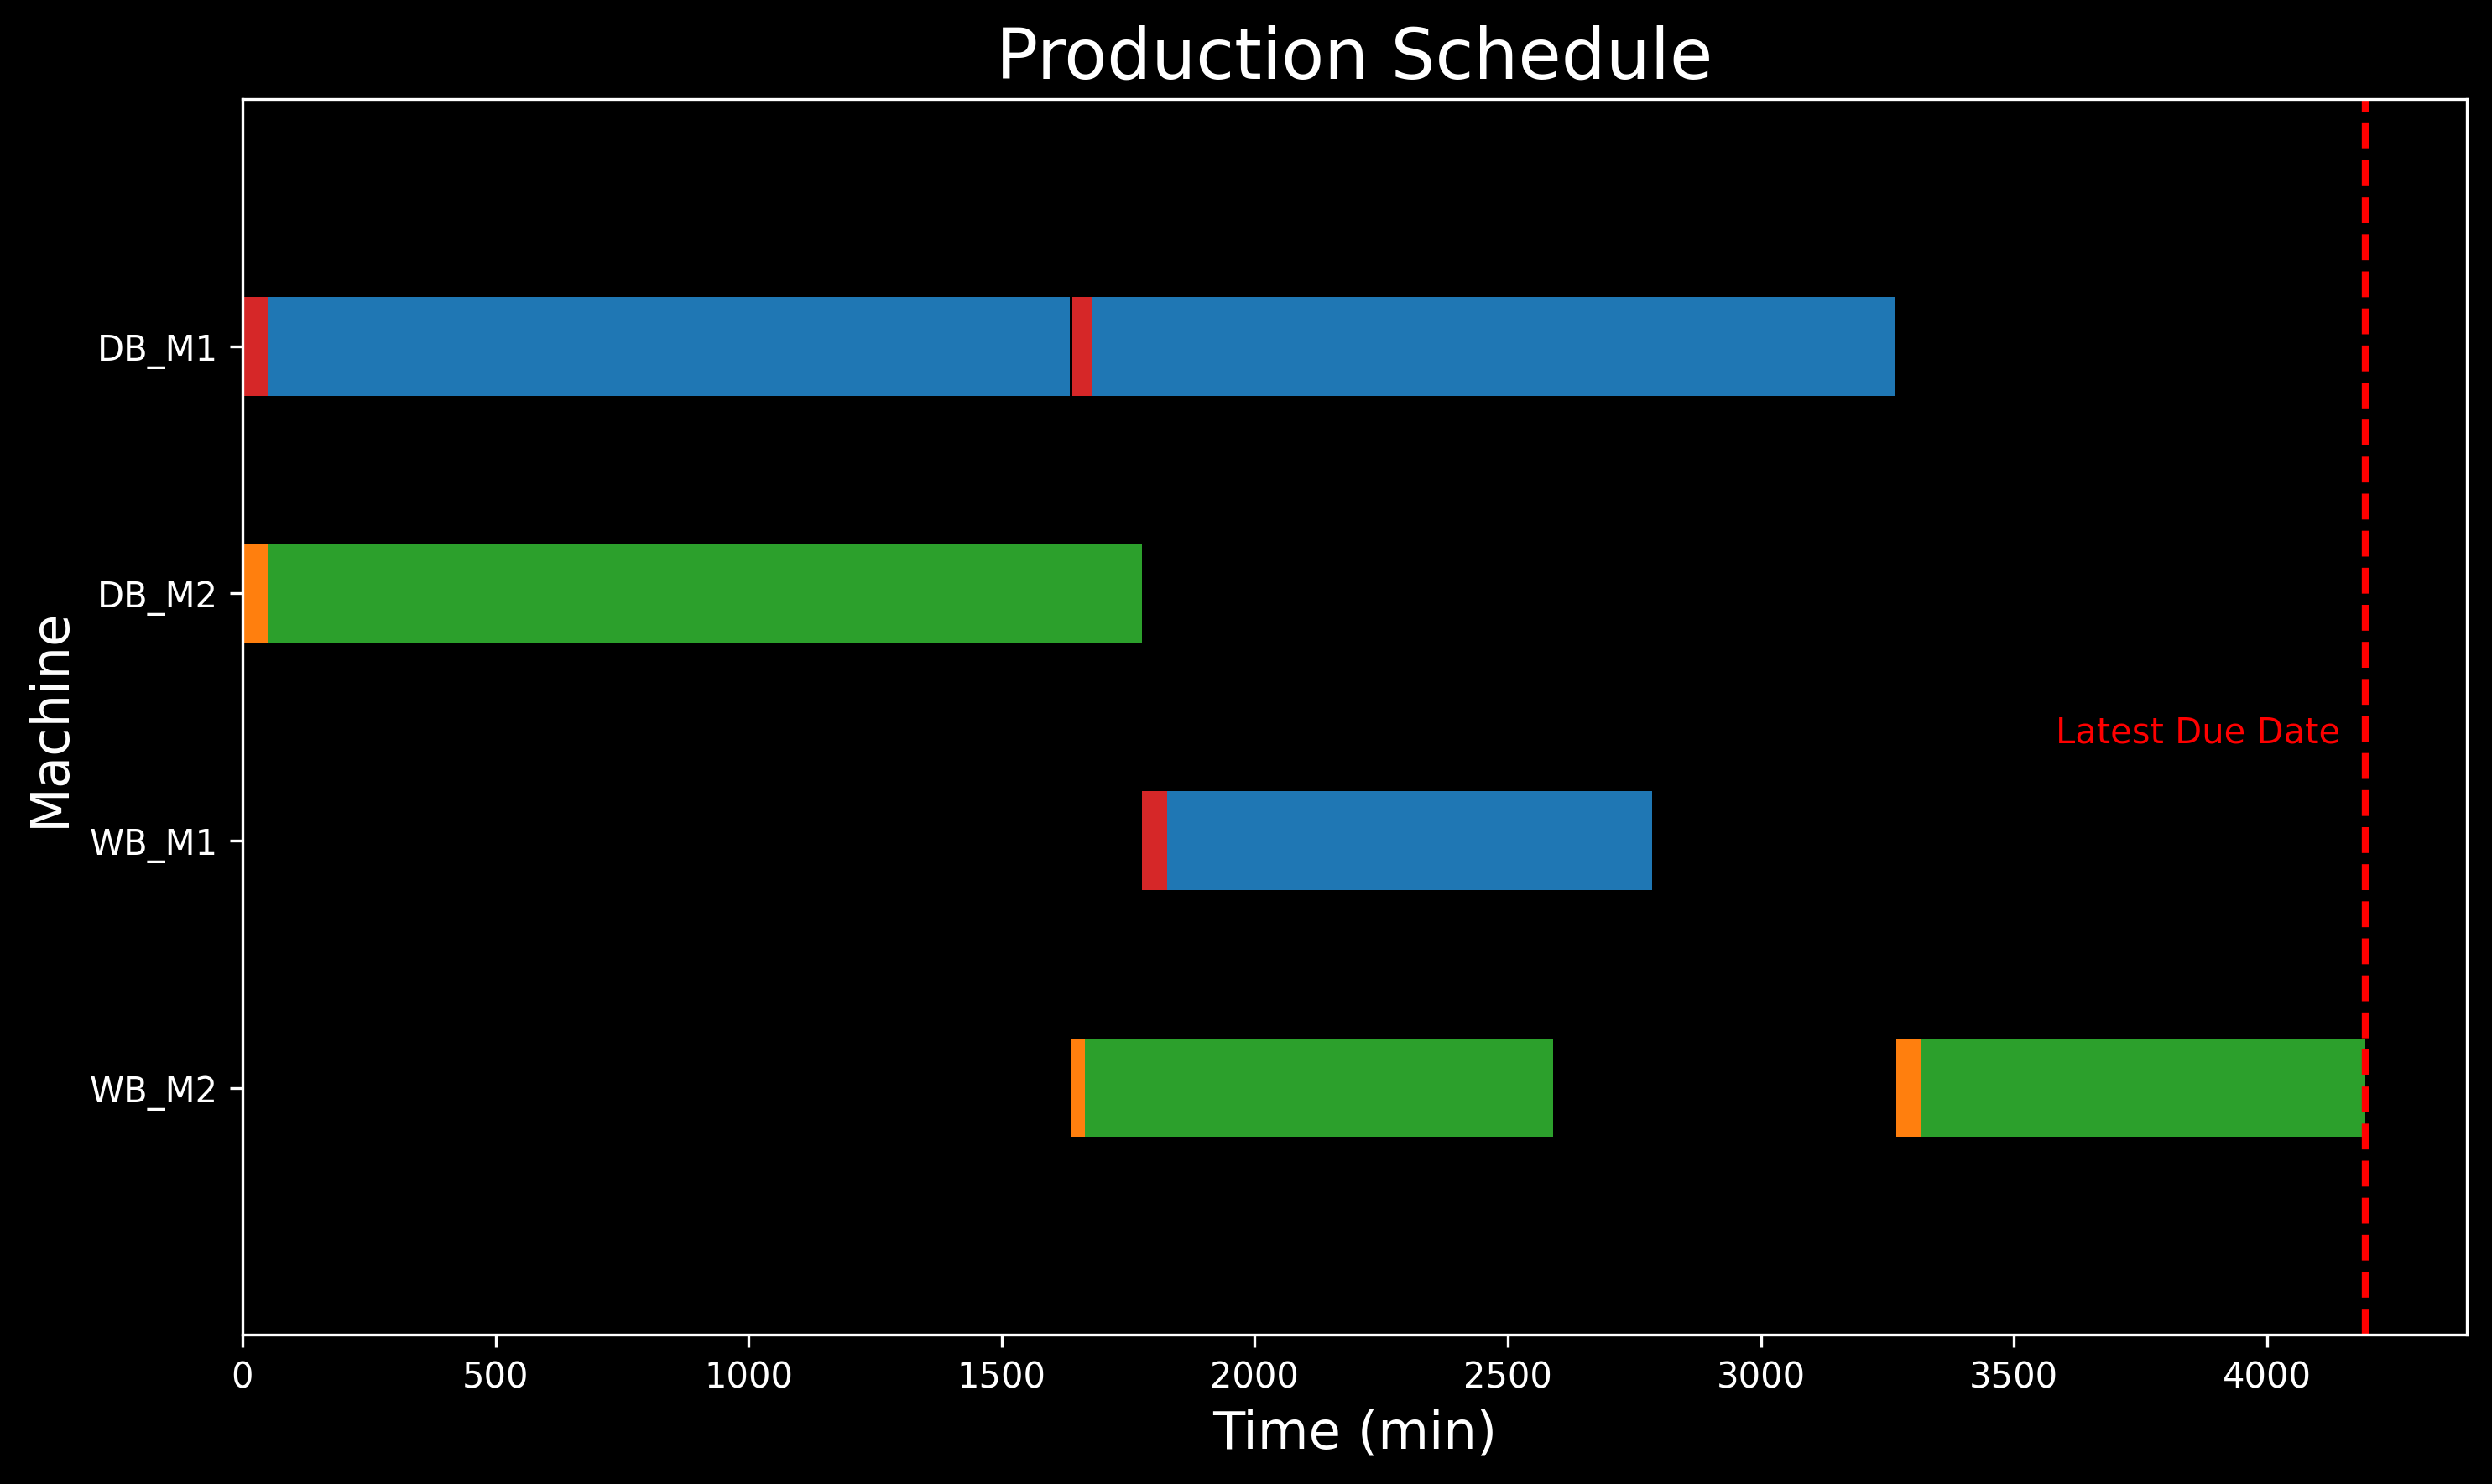

In [13]:
################## plot production gantt chart ##################
import pandas as pd


DB1_st, DB1_pt, DB1_f = [], [], []
DB2_st, DB2_pt, DB2_f = [], [], []
WB1_st, WB1_pt, WB1_f = [], [], []
WB2_st, WB2_pt, WB2_f = [], [], []


for i1 in range(order1):
    for j in range(process):
        if j == 0:
            DB1_st.append(st[i1, j, 0].x)
            DB2_st.append(st[i1, j, 1].x)
            DB1_pt.append(pt[i1, j, 0].x)
            DB2_pt.append(pt[i1, j, 1].x)
            DB1_f.append(f[i1, j].x * x[i1, j, 0].x)
            DB2_f.append(f[i1, j].x * x[i1, j, 1].x)
        else:
            WB1_st.append(st[i1, j, 0].x)
            WB2_st.append(st[i1, j, 1].x)
            WB1_pt.append(pt[i1, j, 0].x)
            WB2_pt.append(pt[i1, j, 1].x)
            WB1_f.append(f[i1, j].x * x[i1, j, 0].x)
            WB2_f.append(f[i1, j].x * x[i1, j, 1].x)

DB1_st_series = pd.Series(DB1_st)
DB2_st_series = pd.Series(DB2_st)
DB1_pt_series = pd.Series(DB1_pt)
DB2_pt_series = pd.Series(DB2_pt)
DB1_f_series = pd.Series(DB1_f)
DB2_f_series = pd.Series(DB2_f)

WB1_st_series = pd.Series(WB1_st)
WB2_st_series = pd.Series(WB2_st)
WB1_pt_series = pd.Series(WB1_pt)
WB2_pt_series = pd.Series(WB2_pt)
WB1_f_series = pd.Series(WB1_f)
WB2_f_series = pd.Series(WB2_f)

c_time = []
for i1 in range(order1):
    c_time.append(c[i1].x)

for i1 in range(order1 - 1):
    if (c_time[i1] - c_time[i1 + 1] >= 0):
        c_max = c_time[i1]
        c_time[i1 + 1] = c_max
    else:
        c_max = c_time[i1 + 1]

import matplotlib.pyplot as plt

fig, gnt = plt.subplots(figsize=(10, 6), dpi=300)

gnt.set_ylim(0, 125)
gnt.set_xlim(0, c_time[order1 - 1] + 200)

gnt.set_yticks([25, 50, 75, 100])
gnt.set_yticklabels(['DB_M1', 'DB_M2', 'WB_M1', 'WB_M2'])

gnt.invert_yaxis()

for i1 in range(order1):
    gnt.broken_barh([(DB1_st_series[i1], DB1_pt_series[i1] - DB1_st_series[i1])], (20, 10), facecolors=('tab:red'))
    gnt.broken_barh([(DB1_pt_series[i1], DB1_f_series[i1] - DB1_pt_series[i1])], (20, 10), facecolors=('tab:blue'))
    gnt.broken_barh([(DB2_st_series[i1], DB2_pt_series[i1] - DB2_st_series[i1])], (45, 10), facecolors=('tab:orange'))
    gnt.broken_barh([(DB2_pt_series[i1], DB2_f_series[i1] - DB2_pt_series[i1])], (45, 10), facecolors=('tab:green'))

    gnt.broken_barh([(WB1_st_series[i1], WB1_pt_series[i1] - WB1_st_series[i1])], (70, 10), facecolors=('tab:red'))
    gnt.broken_barh([(WB1_pt_series[i1], WB1_f_series[i1] - WB1_pt_series[i1])], (70, 10), facecolors=('tab:blue'))
    gnt.broken_barh([(WB2_st_series[i1], WB2_pt_series[i1] - WB2_st_series[i1])], (95, 10), facecolors=('tab:orange'))
    gnt.broken_barh([(WB2_pt_series[i1], WB2_f_series[i1] - WB2_pt_series[i1])], (95, 10), facecolors=('tab:green'))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(c_max, color='red', linestyle='dashed', linewidth=2) # The latest order fulfill
plt.text(c_max-50, 65, 'Latest Due Date', color='red', ha='right')
plt.xlabel('Time (min)', fontsize=15)
plt.ylabel('Machine', fontsize=15)
plt.title('Production Schedule', fontsize=20)

plt.tight_layout()
plt.show()

In [14]:
cce.x

1080.0